In [1]:
# Simulate parity measurement of a 6-qubit stabilizer using a bare ancilla qubit.
# This is an attempt to replicate experimental results from a 15-ion trap in UMd.
# See relevant Mathematica data
from Circuit import Circuit
from Circuit_ops import zero_state, apply, state_prob_plot
from Circuit_ops import find_fidelities, plot_fidelities, save_fidelities, read_fidelities
from Circuit_ops import find_prob, plot_prob
from Circuit_ops import int_to_bit_str, bit_str_to_int
from Error_dist import error_dist
import time
from numpy import *
import numpy as np
# import cupy as cp
import matplotlib.pyplot as plt

N = 7

# Define stabilizer measurement circuit
def stab_meas_circ(bit_str):
    circ = Circuit(N)

    for i in range(len(bit_str)):
        theta = pi/2 * (-1) ** (bit_str[i])
        circ.Y(i, theta)

    qubit_list = [0, 2, 1, 3, 5, 4]

    for i in range(len(qubit_list)):
        theta = pi/2 * (-1) ** i
        circ.XX(qubit_list[i], N - 1, theta)

    for i in range(N - 1):
        circ.Y(i, -pi/2)
        
    return circ

# Give basic statistical info about given set of fidelities
def stat_analysis(results):
    print(f"Number of data = {len(results)}")
    print(f"Average fidelity = {sum(results) / len(results)}")
    print(f"Max fidelity minus Min fidelity = {max(results) - min(results)}")
    print(f"Variance = {var(results)}")

In [2]:
# STEP 1: FIND POSSIBLE ERROR ARRAY
# --- Parallelize circuit runs with different gates and errors ---
def parallel_circ(sim_runs=1, err=[0,0,0], fixed_err=[0,0,0]):
    # Initialize simple circuit
    circ = stab_meas_circ([0,0,0,0,0,0])
    
    # Initialize native and noisy gates
    circ.compute()
    
    # Create new circuit with custom gates
    circ.init_state = zero_state(N)
    circ.runs = 64 * sim_runs

    # Edit noisy gates
    for i in range(0, 6):
        gate_angles = array([])
        
        for k in range(sim_runs):
            for j in range(64):
                gate_angles = concatenate((gate_angles, (pi / 2) * (-1) ** int_to_bit_str(j, N-1)[i] * (1 + err[0] * error_dist(1)))) 
        circ.noisy_gates[i][2][0] = gate_angles
        circ.noisy_gates[i][3][0] = pi / 2 * (1 + err[1] * error_dist(64 * sim_runs))

    for i in range(6, 12):
        # Fixed errors and time-dependent errors
        circ.noisy_gates[i][2][0] = - pi / 2 \
                                    * (1 + fixed_err[2] * repeat(error_dist(sim_runs), 64)) * (1 + err[2] * error_dist(64 * sim_runs))                
        
#         circ.noisy_gates[i][3] = [pi / 2 * err[1] * error_dist(64 * runs), 
#                                     pi / 2 * err[1] * error_dist(64 * runs)]
        circ.noisy_gates[i][3] = [pi / 2 * err[1] * error_dist(64 * sim_runs)
                                  + pi / 2 * fixed_err[2] * repeat(error_dist(sim_runs), 64), 
                                    pi / 2 * err[1] * error_dist(64 * sim_runs)
                                  + pi / 2 * fixed_err[2] * repeat(error_dist(sim_runs), 64)]

    for i in range(12, 18):
        circ.noisy_gates[i][2][0] = - pi / 2 * (1 + err[0] * error_dist(64 * sim_runs))
        circ.noisy_gates[i][3][0] = pi / 2 * (1 + err[1] * error_dist(64 * sim_runs))

    return circ

def run_parallel_circ(sim_runs, err, fixed_err):
#     start = time.time()
    
    circ0 = parallel_circ()
    ideal_states = circ0.compute(compile_gates=False)
    
    circ1 = parallel_circ(sim_runs, err, fixed_err)
    final_states = circ1.compute(compile_gates=False)

#     print(f"Time elapsed = {time.time() - start}")
    
    return final_states, ideal_states, circ1

def fid_dist(final_states, ideal_states, title='', plot=True, analyze=False):
    
    results = []
    
    for i in range(2 ** (N - 1)):
        # -- Getting the correct ancilla --
        measured_qubits = [6]
        
        sub_state = zero_state(1) * 0
        index = (1 + sum(int_to_bit_str(i, N-1))) % 2
        sub_state[index] = 1
        
        probs = find_prob(measured_qubits, sub_state, final_states[i::64])
        results.append(probs)
    
    results = swapaxes(array(results), 0, 1)
        
    
    if plot:
        plt.figure(figsize=(12,6))
        plt.title(f"Probability of getting correct ancilla qubit VS input bit string" if title=='' else title)
        plt.plot(results)
    if analyze:
        stat_analysis(results)
    
    return results

# Note: have to invert parity by one to get the right result, why?

Matching gate angles = 
 [[ 0.0383557   0.00518241 -0.08244987  0.01736276  0.13895503 -0.0063293 ]
 [ 0.00300772  0.12488369 -0.19403624 -0.06926768 -0.02459357  0.00324364]
 [-0.08700875 -0.00688022 -0.02217139 -0.01876949  0.12066872 -0.04468249]
 [ 0.08214876  0.17903757  0.05785486 -0.13457648  0.136766    0.02215501]
 [ 0.08214876  0.17903757  0.05785486 -0.13457648  0.136766    0.02215501]
 [ 0.0400719  -0.03542566  0.24285199  0.06209259  0.00850077 -0.03205399]
 [-0.03656175 -0.04883795  0.14904877 -0.09737573 -0.06023926  0.13147778]
 [-0.07480436 -0.11894182 -0.12189874 -0.04541881  0.08522683 -0.10922057]
 [-0.07480436 -0.11894182 -0.12189874 -0.04541881  0.08522683 -0.10922057]
 [-0.12121844  0.11404692  0.12566678  0.12516191 -0.08832122 -0.12236656]
 [-0.12121844  0.11404692  0.12566678  0.12516191 -0.08832122 -0.12236656]]
Matching gate phases = 
 [[[ 0.05151106  0.14474542]
  [ 0.03877694  0.01133889]
  [-0.02478028  0.02308063]
  [-0.06184259 -0.11071818]
  [-0.151109

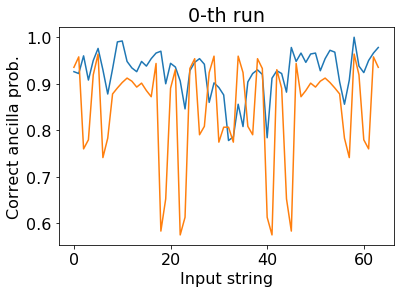

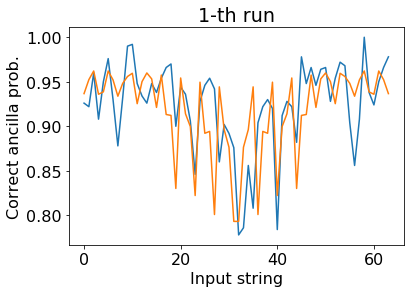

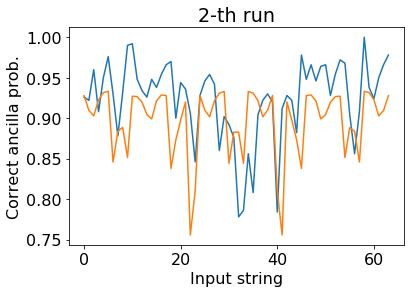

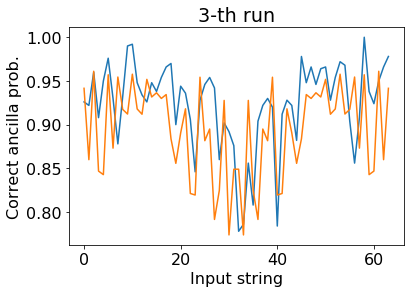

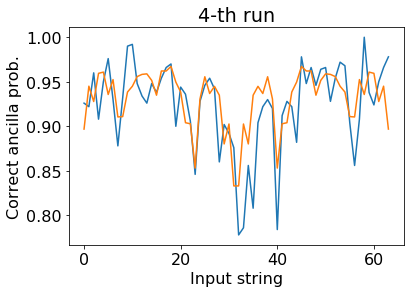

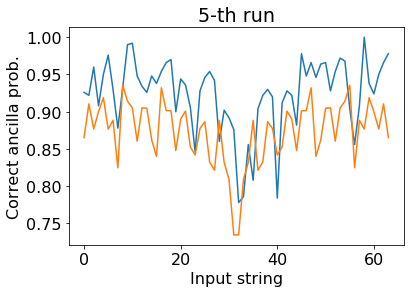

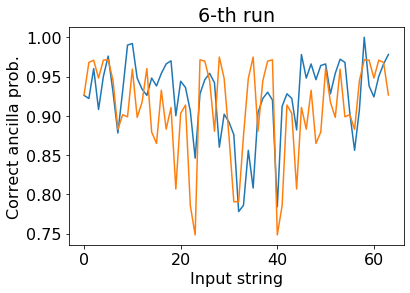

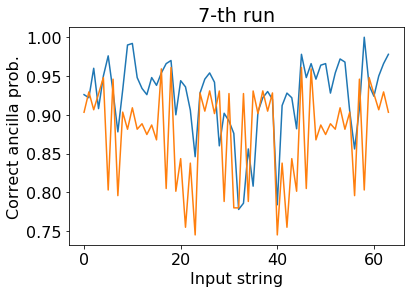

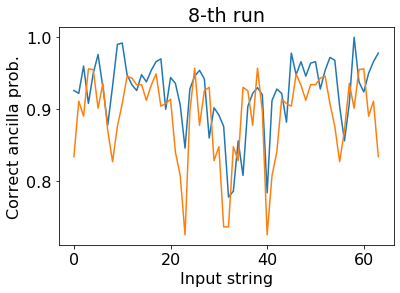

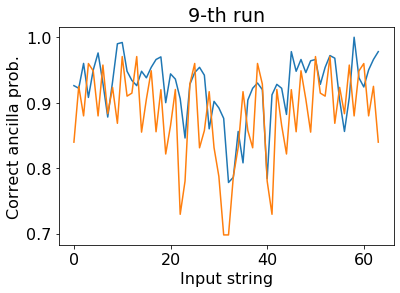

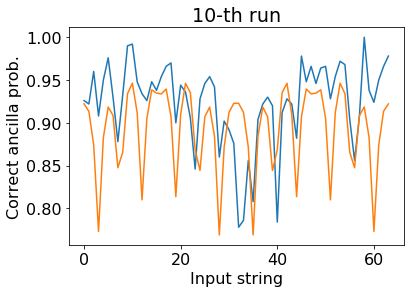

In [3]:
# STEP 2: FIND ERROR VECTOR THAT LEADS TO A FIDELITY DISTRIBUTION MOST SIMILAR TO EXPERIMENT
# Assume no time-dependent errors
err = [0, 0, 0]

# Inputs with lowest fidelities
exp_list = [3, 7, 19, 22, 23, 28, 29, 30, 31]

# Experimental results
all_exp_fids = array([0.826, 0.822, 0.86 , 0.808, 0.85 , 0.876, 0.83 , 0.778, 0.832,
       0.89 , 0.892, 0.848, 0.834, 0.826, 0.848, 0.838, 0.854, 0.866,
       0.87 , 0.8  , 0.844, 0.836, 0.806, 0.746, 0.828, 0.846, 0.854,
       0.842, 0.76 , 0.802, 0.792, 0.776, 0.678, 0.686, 0.756, 0.708,
       0.804, 0.822, 0.83 , 0.82 , 0.684, 0.812, 0.828, 0.822, 0.782,
       0.878, 0.848, 0.866, 0.846, 0.864, 0.866, 0.828, 0.854, 0.872,
       0.868, 0.804, 0.756, 0.808, 0.9  , 0.838, 0.824, 0.85 , 0.866,
       0.878])

start = time.time()

sim_runs = 1000             # Total number of runs
matching_no = 5             # Number of matching peaks required for a match (In this case, 5 out of 9)
matching_results = []       # Store matching results

err = [0, 0, 0]             # TD errors
fixed_err = [0, 0.2, 0.3]   # TI errors (randomomized for every sim run)

# Run circuit and store results
final_states, ideal_states, circ = run_parallel_circ(sim_runs, err, fixed_err)
results = fid_dist(final_states, ideal_states, title=f"Error array = {fixed_err}", plot=False, analyze=False)

plt.rcParams.update({'font.size': 16})

# Find matches
for j in range(sim_runs):
    # List of I/O with lowest fidelities
    fidelities = results[j]
    sim_list = [x for x in argsort(fidelities)[:18] if x < 32]
    sim_list.sort()

    matching_list = [x for x in sim_list if x in exp_list]
    if len(matching_list) > matching_no:
        matching_results.append({"run": j, "fidelities": fidelities, 'lowest_fidelities': sim_list})

matches = len(matching_results)

# Plot fidelities for matches
for i in range(matches):
    plt.figure()
    plt.title(f"{i}-th run")
    # Adjusted results
    plt.plot(array(all_exp_fids) + 0.1)
    plt.plot(matching_results[i]["fidelities"])
    plt.xlabel('Input string')
    plt.ylabel('Correct ancilla prob.')

# Extract relevant gate data from circuit object
def gate_data(circ, matching_results):

    gate_angles = zeros([matches, 6])
    gate_phases = zeros([matches, 6, 2])
    
    for j in range(matches):
        for i in range(6, 12):
            run = matching_results[j]["run"]
            gate_angle = circ.noisy_gates[i][2][0][run]
            gate_phase0 = circ.noisy_gates[i][3][0][run]
            gate_phase1 = circ.noisy_gates[i][3][1][run]
            gate_angles[j][i - 6] = gate_angle / (pi/2) + 1
            gate_phases[j][i - 6][0] = gate_phase0 / (pi/2)
            gate_phases[j][i - 6][1] = gate_phase1 / (pi/2)
        
    return gate_angles, gate_phases

gate_angles, gate_phases = gate_data(circ, matching_results)
print(f"Matching gate angles = \n {gate_angles}")
print(f"Matching gate phases = \n {gate_phases}")
print(f"Time elapsed = {time.time() - start} s")

In [13]:
circ.ideal_gates

[['Y', 0, 1.5707963267948966, None],
 ['Y', 1, 1.5707963267948966, None],
 ['Y', 2, 1.5707963267948966, None],
 ['Y', 3, 1.5707963267948966, None],
 ['Y', 4, 1.5707963267948966, None],
 ['Y', 5, 1.5707963267948966, None],
 ['XX', [0, 6], 1.5707963267948966, None],
 ['XX', [2, 6], -1.5707963267948966, None],
 ['XX', [1, 6], 1.5707963267948966, None],
 ['XX', [3, 6], -1.5707963267948966, None],
 ['XX', [5, 6], 1.5707963267948966, None],
 ['XX', [4, 6], -1.5707963267948966, None],
 ['Y', 0, -1.5707963267948966, None],
 ['Y', 1, -1.5707963267948966, None],
 ['Y', 2, -1.5707963267948966, None],
 ['Y', 3, -1.5707963267948966, None],
 ['Y', 4, -1.5707963267948966, None],
 ['Y', 5, -1.5707963267948966, None]]

In [4]:
# STEP 3: TINKER WITH MATCHING ERROR VECTORS AND RERUN CIRCUIT WITH NEW VECTORS
def adjusted_parallel_circ(sim_runs=1, err=[0,0,0], err_arr=[0]*6):
    circ = stab_meas_circ([0,0,0,0,0,0])
    circ.compute()
    
    # Create new circuit with custom gates
    circ.init_state = zero_state(N)
    circ.runs = 64
    
    # Edit noisy gates
    for i in range(0, 6):
        gate_angles = array([])
        
        for j in range(64):
            gate_angles = concatenate((gate_angles, (pi / 2) * (-1) ** int_to_bit_str(j, N-1)[i] * (1 + err[0] * error_dist(1)))) 
        circ.noisy_gates[i][2][0] = gate_angles
        circ.noisy_gates[i][3][0] = pi / 2 * (1 + err[1] * error_dist(64 * sim_runs))

    for i in range(6, 12):
        # Fixed errors and time-dependent errors
        circ.noisy_gates[i][2][0] = - pi / 2 \
                                    * (1 + err_arr[i-6]) \
                                    * (1 + err[2] * error_dist(64 * sim_runs))

        # No phase errors
        circ.noisy_gates[i][3] = [pi / 2 * err[1] * error_dist(64 * sim_runs)
                                  + pi / 2 * 0 * repeat(error_dist(sim_runs), 64), 
                                    pi / 2 * err[1] * error_dist(64 * sim_runs)
                                  + pi / 2 * 0 * repeat(error_dist(sim_runs), 64)]

    for i in range(12, 18):
        circ.noisy_gates[i][2][0] = - pi / 2 * (1 + err[0] * error_dist(64 * sim_runs))
        circ.noisy_gates[i][3][0] = pi / 2 * (1 + err[1] * error_dist(64 * sim_runs))

    return circ

# Find ideal states    
circ_new0 = adjusted_parallel_circ()
ideal_states = circ_new0.compute(compile_gates=False)

# Find final states due to adjusted param. vector
circ_new1 = adjusted_parallel_circ(err_arr=gate_angles[0])
final_states = circ_new1.compute(compile_gates=False)


def adjusted_fid_dist(final_states, ideal_states, title='', plot=True, analyze=False):
    
    results = []
    
    for i in range(2 ** (N - 1)):
        # -- Getting the correct ancilla --
        measured_qubits = [6]
        
        sub_state = zero_state(1) * 0
        index = (1 + sum(int_to_bit_str(i, N-1))) % 2
        sub_state[index] = 1
        
        probs = find_prob(measured_qubits, sub_state, tile(final_states[i], (2, 1)))
        results.append(probs)
    
    results = swapaxes(array(results), 0, 1)
        
#     print(results.shape)
    if plot:
        plt.figure(figsize=(12,6))
        plt.title(f"Probability of getting correct ancilla qubit VS input bit string" if title=='' else title)
        plt.plot(results[0])
    if analyze:
        stat_analysis(results)
    
    return results

results = adjusted_fid_dist(final_states, ideal_states)
plt.plot(matching_results[0]["fidelities"])
plt.show()

NameError: name 'gate_angles' is not defined

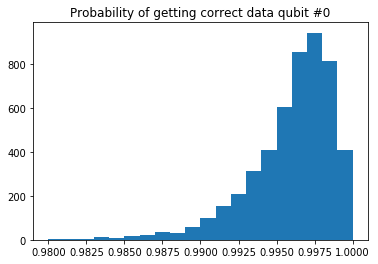

Average probability = 0.9959639697834013
10-th percentile probability = 0.9922476561163477
90-th percentile probability = 0.9988698890988268


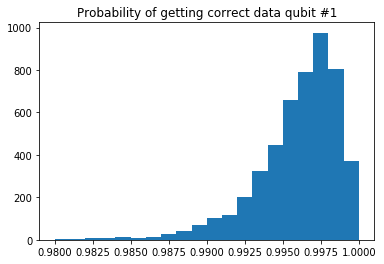

Average probability = 0.9959556487090753
10-th percentile probability = 0.9924560052907562
90-th percentile probability = 0.9988052178979763


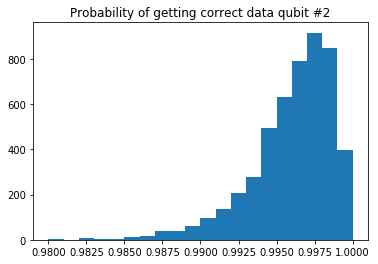

Average probability = 0.995996252724819
10-th percentile probability = 0.9923645707637533
90-th percentile probability = 0.9988616231120225


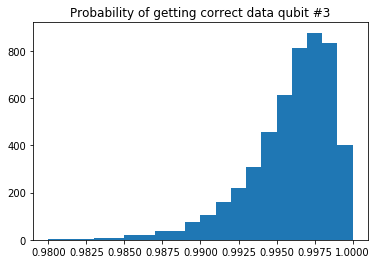

Average probability = 0.9958952066747941
10-th percentile probability = 0.9920816945026032
90-th percentile probability = 0.9988547423002659


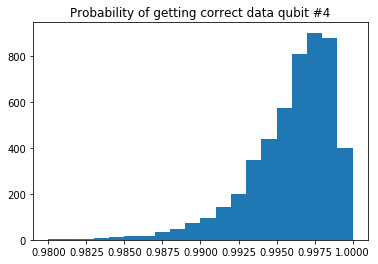

Average probability = 0.9959449989594159
10-th percentile probability = 0.9922062123811115
90-th percentile probability = 0.9988677126861792


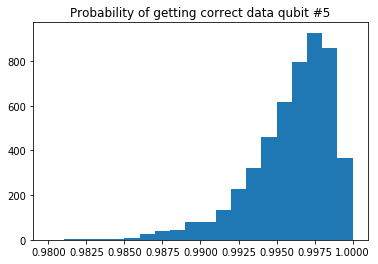

Average probability = 0.9959523739479439
10-th percentile probability = 0.9923057866272333
90-th percentile probability = 0.998796168287057


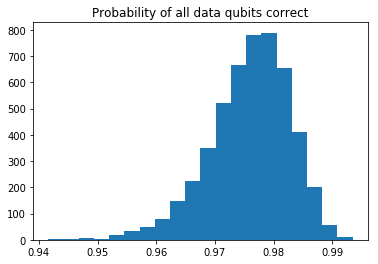

Average probability = 0.9759533048095033
10-th percentile probability = 0.966849366564849
90-th percentile probability = 0.984012557335818


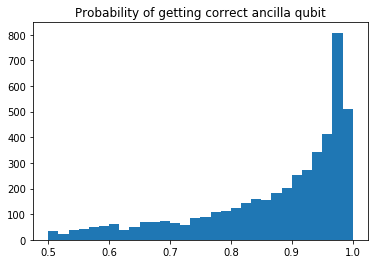

Average probability = 0.8397224181502974
10-th percentile probability = 0.5865125601072161
90-th percentile probability = 0.9834849996669842


In [109]:
# PURE SIMULATION: FIDELITY DISTRIBUTION FOR DIFFERENT TIME-DEPENDENT ERROR DISTRIBUTIONS

bit_str = [0, 0, 1, 0, 0, 1]
circ = stab_meas_circ(bit_str)
circ.errors = [0.1, 0.1, 0.6]
circ.runs = 5000
final_states = circ.compute()

# -- Probability of measuring data qubits correctly (individual) --
for i in range(N-1):
    measured_qubits = [i]
    sub_state = zero_state(1) * 0
    sub_state[bit_str[i]] = 1
    probs = find_prob(measured_qubits, sub_state, final_states)

    title = f"Probability of getting correct data qubit #{i}"
    plot_prob(probs, range=(0.98, 1), title=title)

# -- Probability of getting all data qubits correct --
measured_qubits = list(range(N - 1))
sub_state = zero_state(N - 1) * 0
sub_state[bit_str_to_int(bit_str)] = 1

probs = find_prob(measured_qubits, sub_state, final_states)

title = f"Probability of all data qubits correct"
plot_prob(probs, title=title)

# -- Getting the correct ancilla --
measured_qubits = [6]
sub_state = zero_state(1) * 0
sub_state[0] = 1

probs = find_prob(measured_qubits, sub_state, final_states)

title = f"Probability of getting correct ancilla qubit"
plot_prob(probs, range=(0.5, 1), bins=30, title=title)



In [ ]:
# Parity plots?
# Simulate state prep errors: additional rotation?
# Simulate measurement errors: probabilistic?

# Errors correlated --> independent measurement errors don't explain high parity correlation

# Y-covariance? Fidelity below average more extreme than above average --> coherent errors dominate
# How to take into account incoherent type errors (e.g. incoherent type motion)?
